# Topics
* [Fourier Transform](#1)
* [Operations in frequency domain](#2)



In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
FLOWER_IMAGE = 'flower.jpeg'

IMAGE_SHAPE = (350, 350)

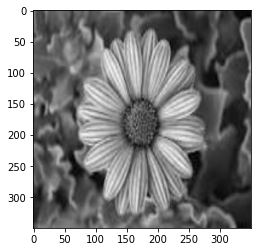

In [3]:
flower_im = cv2.imread(FLOWER_IMAGE, 0)
flower_im = cv2.resize(flower_im, IMAGE_SHAPE)
plt.imshow(flower_im, cmap='gray');

In [4]:
def plot_spectogram(ft, cmap='gray', title=None):
    spectogram = 20 * np.log(np.abs(ft))
    plt.subplot(121), plt.imshow(spectogram, cmap=cmap)
    plt.xticks([]), plt.yticks([]), plt.title(title)

np_ifft = lambda x : np.real(np.fft.ifft2(np.fft.ifftshift(x)))

def cv_idft(x):
    x2 = cv2.idft(np.fft.ifftshift(x))
    return cv2.magnitude(x2[:, :, 0], x2[:, :, 1])


<a id=1></a>
# Fourier Transform

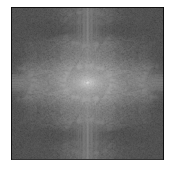

In [5]:
ft = np.fft.fft2(flower_im)
ft = np.fft.fftshift(ft)
spectrum = 20*np.log(np.abs(ft))
plot_spectogram(ft)

<a id=2></a> 
## Operations in frequency domain
`1`. Scaling<br>
`2`. Edge detection.<br>
`3`. Blurring, Smoothing.

### Scaling

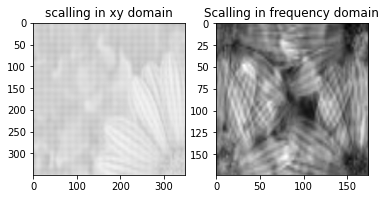

In [6]:
SCALE_FACTOR = 2
X_, Y_ = np.int16(np.arange(350) * SCALE_FACTOR), np.int16(np.arange(350) * SCALE_FACTOR)

scaled_im = np.ones(IMAGE_SHAPE) * 255
for i in range(350):
    for j in range(350):
        try:
            color = flower_im[i, j]
            scaled_im[X_[i], Y_[j]] = color
        except IndexError:
            continue
plt.subplot(121)
plt.imshow(scaled_im, cmap='gray');plt.title('scalling in xy domain')


# in frequency domain
ft = cv2.dft(np.float32(flower_im), flags=cv2.DFT_COMPLEX_OUTPUT)
fshift = np.fft.fftshift(ft)
XF_, YF_ = np.int16(np.arange(fshift.shape[0]) / SCALE_FACTOR), np.int16(np.arange(fshift.shape[1]) / SCALE_FACTOR)
scaled_ft = np.ones((XF_.max(), YF_.max(), 2))

for i in range(350):
    for j in range(350):
        try:
            color1, color2 = fshift[i, j]
            scaled_ft[XF_[i], YF_[j]] = color1 / SCALE_FACTOR, color2 / SCALE_FACTOR
        except IndexError:
            continue
img_back = cv_idft(scaled_ft)
plt.subplot(122)
plt.imshow(img_back, cmap='gray')
plt.title('Scalling in frequency domain');

<font size=3>Note:</font> <font color='red'>**aliasing**</font> happened when moving from xy domain to frequency domain

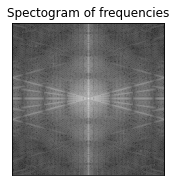

In [7]:
square_im = cv2.imread('square.png')[:, :, 0]
ft = cv2.dft(np.float32(square_im), flags=cv2.DFT_COMPLEX_OUTPUT)
ft = np.fft.fftshift(cv2.magnitude(ft[:, :, 0], ft[:, :, 1]))
spectrum = 20*np.log(np.abs(ft))
plot_spectogram(ft, title='Spectogram of frequencies')

<font size=3>There are two ways of getting fft either using <font color='red'>**numpy fft**</font> or using <font color='red'>**opencv dft**</font></font>

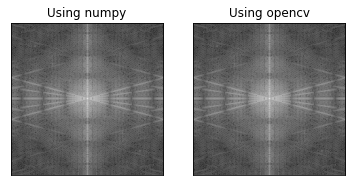

In [8]:
# first using numpy.fft.fft2

ft = np.fft.fft2(square_im)
fshift = np.fft.fftshift(ft)
spectrum = 20*np.log(np.abs(fshift))

# second using cv2.dft

ft_ = cv2.dft(np.float32(square_im), flags=cv2.DFT_COMPLEX_OUTPUT)
fshift_ = np.fft.fftshift(ft_)
spectrum_ = 20*np.log(np.abs(cv2.magnitude(fshift_[:, :, 0], fshift_[:, :, 1])))


plt.subplot(121)
plot_spectogram(fshift, title='Using numpy')

plt.subplot(122)
plt.imshow(spectrum_, cmap='gray')
plt.xticks([]), plt.yticks([]), plt.title('Using opencv');

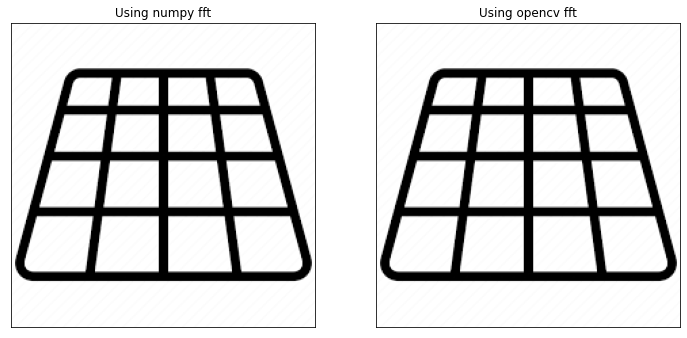

In [9]:
rows, cols = square_im.shape
crows, ccols = rows//2, cols//2
wx, wy = 0, 0
fshift[crows - wx : crows + wx, ccols - wy : ccols + wy] = 0

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(np_ifft(fshift), cmap='gray')
plt.title("Using numpy fft"), plt.xticks([]), plt.yticks([]);

fshift_[crows - wx : crows + wx, ccols - wy : ccols + wy] = 0
img_back = cv_idft(fshift_)

plt.subplot(122)
plt.imshow(img_back, cmap='gray')
plt.title("Using opencv fft"), plt.xticks([]), plt.yticks([]);

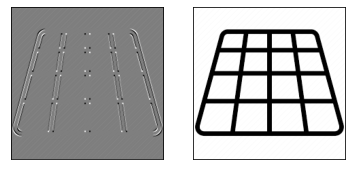

In [10]:
# edge detection using sobel operator
sobel_edges = cv2.Sobel(square_im, ddepth=cv2.CV_16S, dx=1, dy=1)

plt.subplot(121)
plt.imshow(sobel_edges, cmap='gray');plt.xticks([]), plt.yticks([]);

plt.subplot(122)
plt.imshow(np_ifft(fshift), cmap='gray');plt.xticks([]), plt.yticks([]);

### Smoothing
<font size=3> Remember in x, y domain we blurred image by convoluting a gaussian filter over the image, <br>
In frequency domain convolution operation is turned into multiplication where:<br>
$$ if: y(t) = h(t) * x(t)$$   $$ Then:   Y(\omega) = H(\omega)X(\omega)$$ </font>

#### remember: 
Gaussian filter equation:

$$ G = \frac{1}{2\pi\sigma^2}e^{- \frac{x^2 + y^2}{2*\sigma^2}}$$

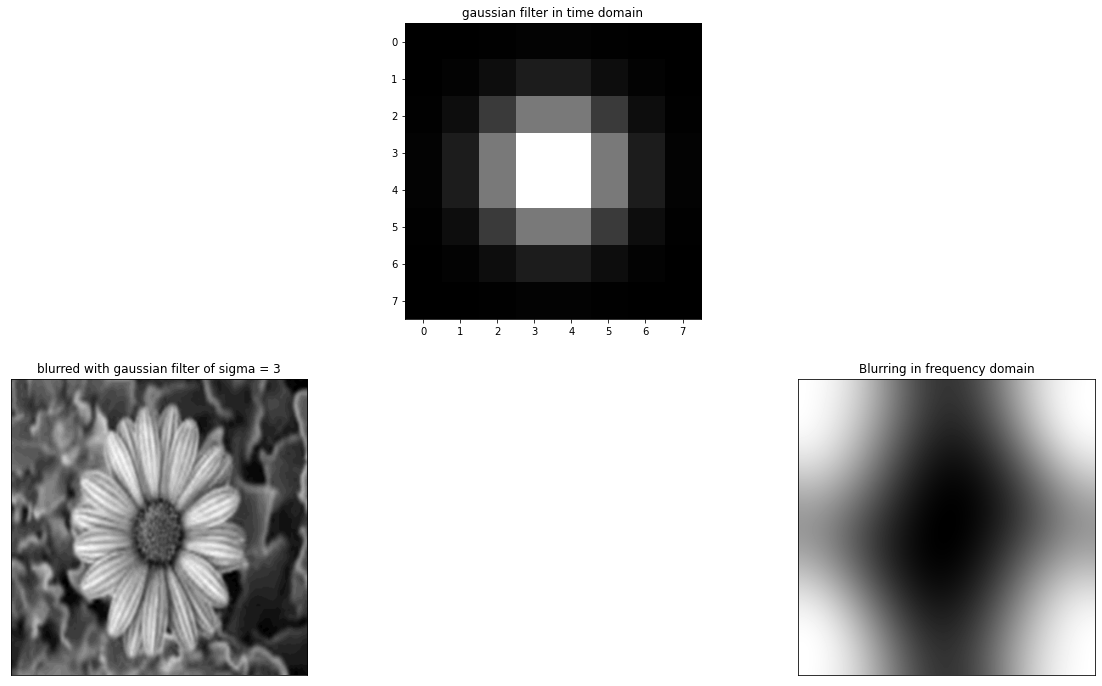

In [11]:
# first create low path gaussian filter
sigma = 3
kernel_size = 8
plt.figure(figsize=(20, 12))

x, y = np.meshgrid(np.linspace(-1, 1, kernel_size), np.linspace(-1, 1, kernel_size))
filter = np.exp(- (x**2 + y**2) / 2*sigma**2) / (2*np.pi*sigma**2)

plt.subplot(232)
plt.imshow(filter, cmap='gray')
plt.title('gaussian filter in time domain')

blurred_im = cv2.filter2D(flower_im, ddepth=-1, kernel=filter)
plt.subplot(234)
plt.imshow(blurred_im, cmap='gray')
plt.title(f'blurred with gaussian filter of sigma = {sigma}'), plt.xticks([]), plt.yticks([]);


# blur in fourier domain

flower_ft = cv2.dft(np.float32(flower_im), flags=cv2.DFT_COMPLEX_OUTPUT)
shift_flower = np.fft.fftshift(flower_ft)

filter_ft = cv2.dft(np.float32(filter), flags=cv2.DFT_COMPLEX_OUTPUT)
shift_filter = np.fft.fftshift(filter_ft) * 210
h = len(shift_filter) // 2

m, n, _ = shift_flower.shape
full_filter = np.zeros((m, n, 2))
full_filter[m//2-h:m//2+h, n//2-h:n//2+h] = shift_filter

blurred_im = shift_flower * full_filter
img_back = cv_idft(blurred_im)

plt.subplot(236)
plt.imshow(img_back, cmap='gray')
plt.title('Blurring in frequency domain'), plt.xticks([]), plt.yticks([]);

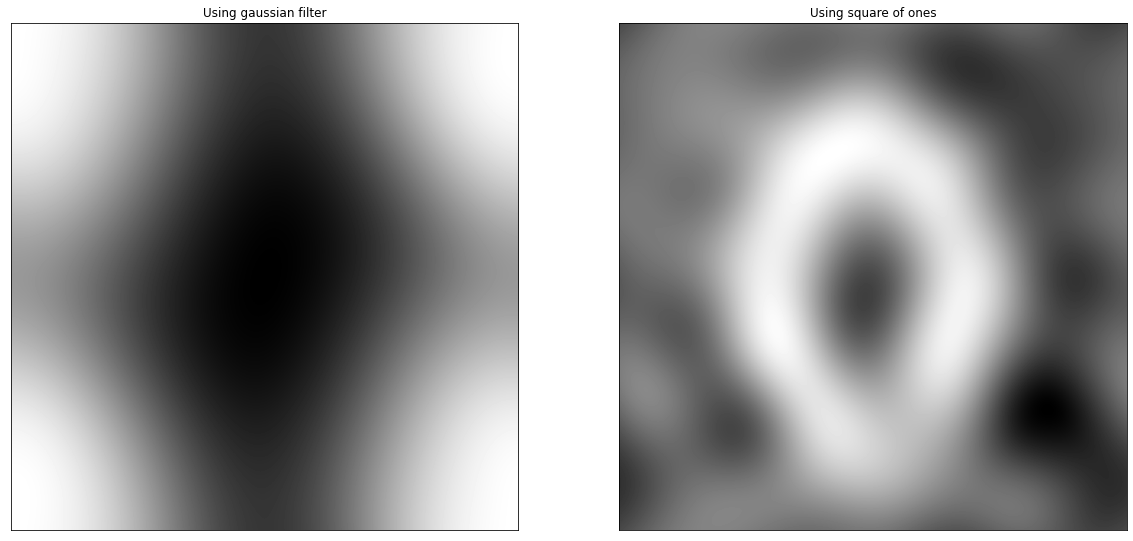

In [12]:
# using ones mask instead of gaussian filter

rows, cols = flower_im.shape
crow,ccol = rows//2 , cols//2
mask_size = 8 // 2

mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-mask_size:crow+mask_size, ccol-mask_size:ccol+mask_size] = 1

fshift = shift_flower * mask
img_back_ = cv_idft(fshift)

plt.figure(figsize=(20, 12))
plt.subplot(121),plt.imshow(img_back, cmap = 'gray')
plt.title('Using gaussian filter'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back_, cmap = 'gray')
plt.title('Using square of ones'), plt.xticks([]), plt.yticks([])
plt.show()